## Load Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import arviz as az
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.budget_optimizer import calculate_expected_contribution
from sklearn.metrics import mean_absolute_error

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

In [2]:
df = pd.read_csv('data/data.csv')
df = df.rename(columns={'Unnamed: 0': 'id', 'TV Ad Budget ($)':'tv', 'Radio Ad Budget ($)': 'radio', 'Newspaper Ad Budget ($)': 'newspaper', 'Sales ($)': 'sales'})
df.head()

,id,tv,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## Exploratory Data Analysis

1. Let's consider that the sales are timely order based on id in order to extract control variables such as seasonality and trend.
2. For that, we will create a new column called `ds` that bring weekly granularity to the data.

In [3]:
df['ds'] = df['id'].apply(lambda x: pd.to_datetime("2024-02-26")-datetime.timedelta(weeks=len(df)-x))
df

,id,tv,radio,newspaper,sales,ds
0,1,230.1,37.8,69.2,22.1,2020-05-04
1,2,44.5,39.3,45.1,10.4,2020-05-11
2,3,17.2,45.9,69.3,9.3,2020-05-18
3,4,151.5,41.3,58.5,18.5,2020-05-25
4,5,180.8,10.8,58.4,12.9,2020-06-01
...,...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6,2024-01-29
196,197,94.2,4.9,8.1,9.7,2024-02-05
197,198,177.0,9.3,6.4,12.8,2024-02-12
198,199,283.6,42.0,66.2,25.5,2024-02-19


#### Sales over time:
 - There is no clear trend or seasonality in sales.

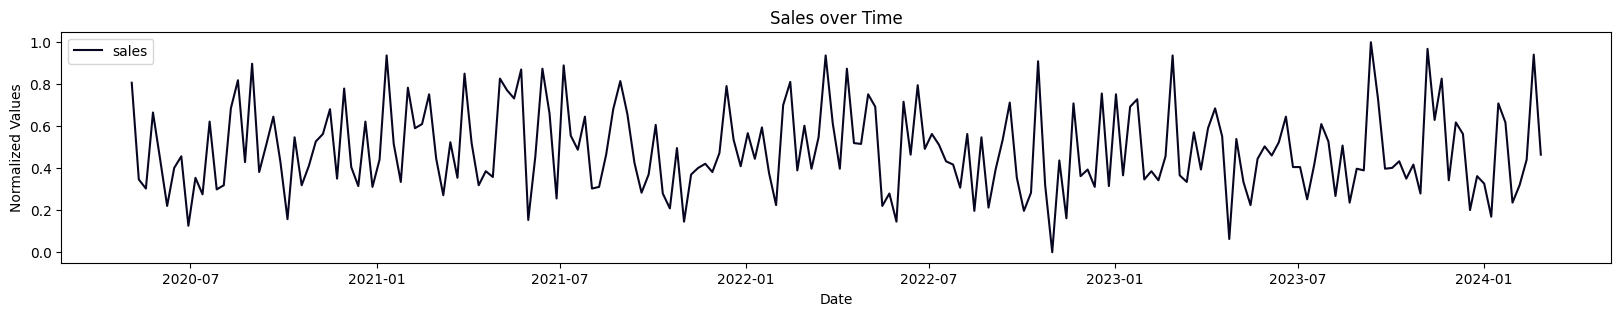

In [4]:
utils.line_plot(df.copy(), ['sales'], 'Sales over Time')

#### Correlation between variables:
 - TV is the most correlated feature with sales
 - Newspaper is the least correlated feature with sales

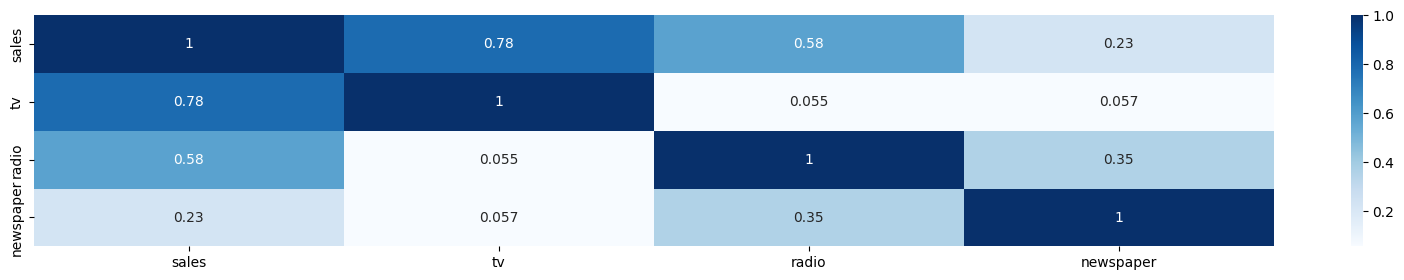

In [38]:
corr_matrix = df[['sales', 'tv', 'radio', 'newspaper']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()


#### Tv vs Sales:
 - The effect from TV advertisement seems to have an immediate impact in sales

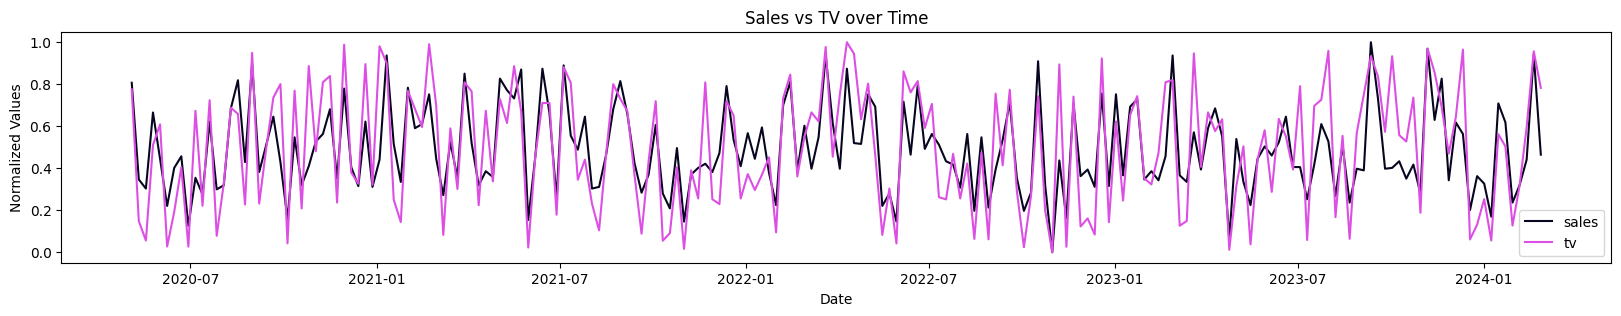

In [34]:
utils.line_plot(df.copy(), ['sales', 'tv'], 'Sales vs TV over Time')

#### Radio vs Sales:
 - The effect from Radio advertisement seems to have an immediate impact in sales, for example week 1,2 and 3 in 2022 where TV had lower values of advertisement, we see 2 spikes in sales which matches the spikes in Radio. 

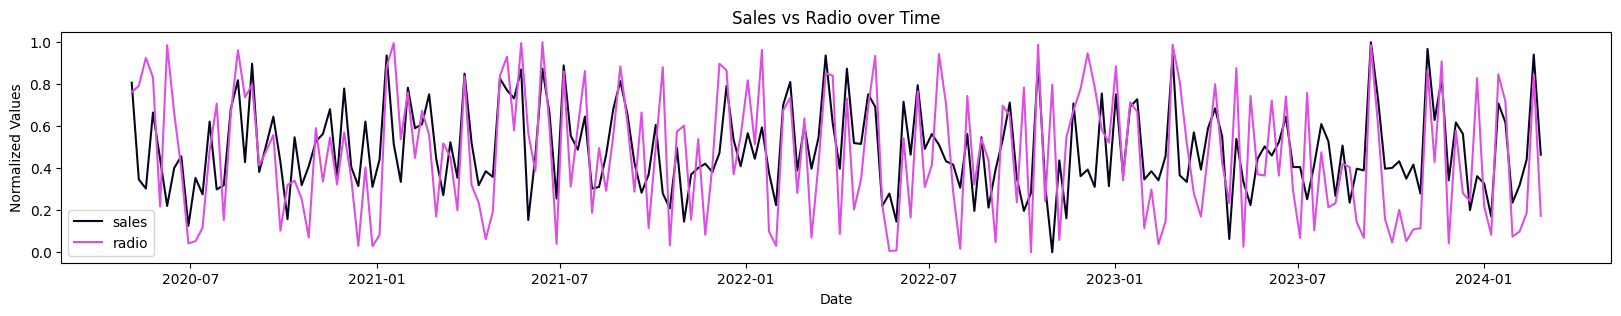

In [33]:
utils.line_plot(df.copy(), ['sales', 'radio'], 'Sales vs Radio over Time')

#### Newspaper vs Sales:
 - The effect from Newspaper advertisement seems to have a 1-2 week of lag, but it is hard to tell since there are TV and Radio advertisements running at the same time

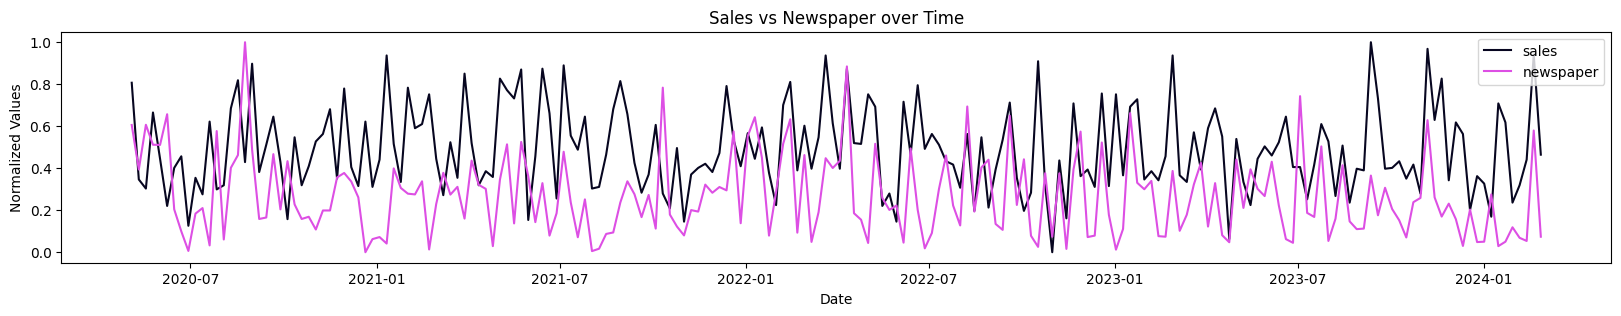

In [32]:
utils.line_plot(df.copy(), ['sales', 'newspaper'], 'Sales vs Newspaper over Time')

### Maketing Mix Modelling

- Start by spliting the data into train and test

In [5]:
train_df = df.sort_values(by='ds').iloc[:-5,:]
test_df = df.sort_values(by='ds').iloc[-5:,:]

- Enrich the dataset by adding control variables such as trend and seasonality based on Prophet decomposition

11:19:47 - cmdstanpy - INFO - Chain [1] start processing
11:19:48 - cmdstanpy - INFO - Chain [1] done processing
/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProp

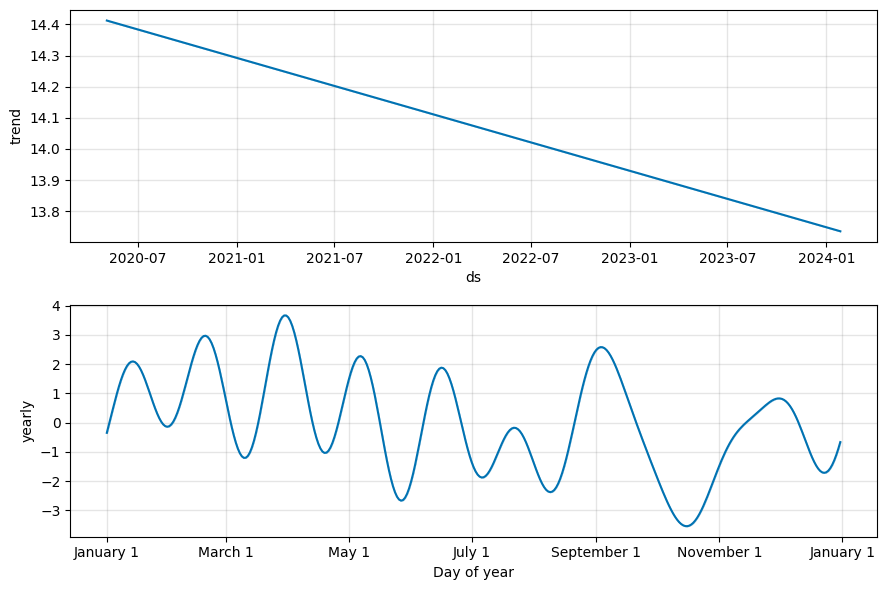

In [6]:
seasonality, trend = utils.extract_trend_seasonality(train_df, 'sales', 5)
train_df.loc[:, 'seasonality'] = seasonality[:-5]
test_df.loc[:,'seasonality'] = seasonality[-5:]
train_df.loc[:,'trend'] = trend[:-5]
test_df.loc[:,'trend'] = trend[-5:]

- Define model config
    - higher std (sigma) gives more freedom to the model during the search of the optimal parameter.

In [7]:
my_model_config = {'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}}}

-  Fit Bayesian Model
    - media channels `["tv", "radio", "newspaper"]`
    - control variables `["seasonality", "trend"]`
    - from EDA max adstock lag does not seem higher than 2
    - train the model

In [8]:
mmm = DelayedSaturatedMMM(
    model_config=my_model_config,
    sampler_config={"progressbar": True},
    date_column="ds",
    channel_columns=["tv", "radio", "newspaper"],
    control_columns=["seasonality", "trend"],
    adstock_max_lag=2,
)


mmm.fit(X=train_df[['ds', 'tv', 'radio', "newspaper", "seasonality", "trend"]], y=train_df['sales'], target_accept=0.95, chains=4, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, likelihood_sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 844 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

### Model ability to fit the training Data
- Checking how well the sampling predictions (blue) follow the model (black).
- In our case, we have a pretty good alignment

Sampling: [y]


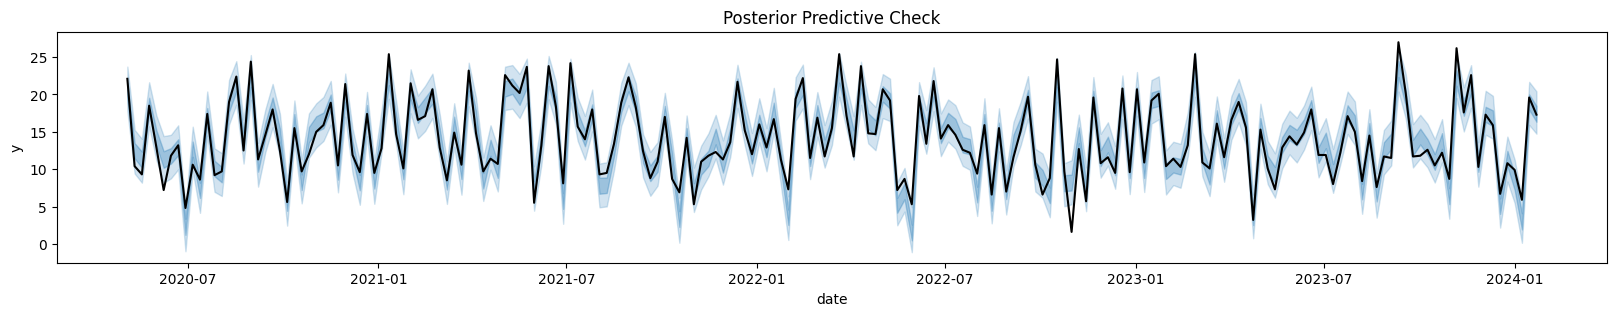

In [8]:
plt.rcParams["figure.figsize"] = (20,3)
mmm.sample_posterior_predictive(train_df[['ds', 'tv', 'radio', "newspaper", "seasonality", "trend"]], extend_idata=True, combined=True)
mmm.plot_posterior_predictive(original_scale=True);

### Model interpretation
 - Radio seems to have the most return of investment since its coefficient (beta) is the highest (1.636), followed by TV and Newspaper
 - The retention rate (alpha) is 3.2% for TV, 2.3% for Radio and 23.9% for Newspaper
 - The saturation rate (lam) is higher on TV (3.138) which owns 73% of the total spend

In [9]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.092,0.293,-0.679,0.427,0.006,0.005,2311.0,2399.0,1.0
likelihood_sigma,0.057,0.003,0.051,0.063,0.000,0.000,4036.0,2700.0,1.0
beta_channel[tv],0.556,0.025,0.510,0.602,0.001,0.000,2622.0,2303.0,1.0
beta_channel[radio],1.185,0.572,0.464,2.184,0.013,0.009,2212.0,2391.0,1.0
beta_channel[newspaper],0.034,0.071,0.000,0.097,0.001,0.001,2036.0,2092.0,1.0
alpha[tv],0.032,0.020,0.000,0.068,0.000,0.000,2248.0,1302.0,1.0
alpha[radio],0.023,0.019,0.000,0.058,0.000,0.000,2566.0,1489.0,1.0
alpha[newspaper],0.239,0.191,0.000,0.595,0.003,0.002,3615.0,1834.0,1.0
lam[tv],3.138,0.324,2.527,3.737,0.006,0.004,3080.0,2131.0,1.0
lam[radio],0.757,0.312,0.224,1.342,0.006,0.005,2228.0,2551.0,1.0


### Media Channel contribution
- According to the model, TV is responsible for about 65% of the additional sales (additional to the base), radio for about 33%, and newspaper for about 2%.

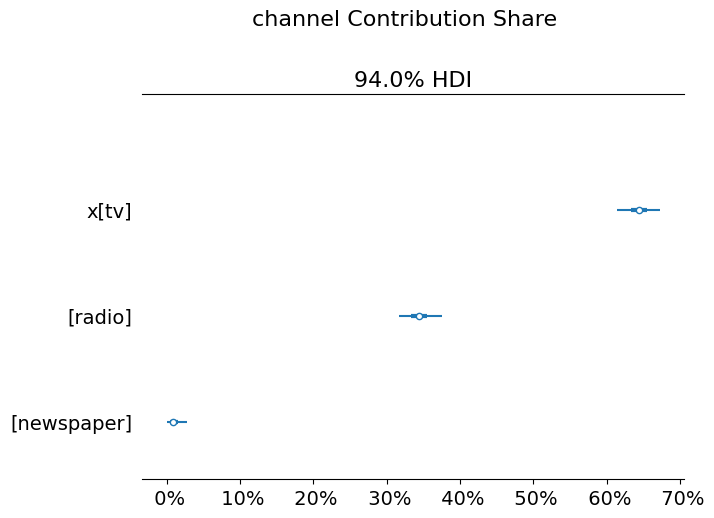

In [10]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))

- As mentioned before and as seen in the chart below, Radio is the channel with the highes Return On Ad Spend (ROAS)

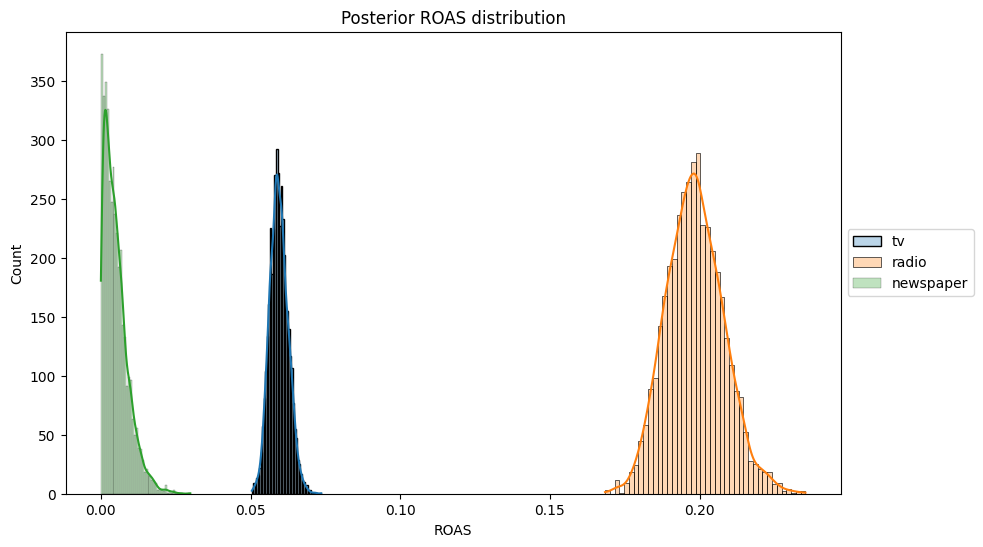

In [11]:
utils.plot_ROAS(mmm, train_df, ["tv", "radio", "newspaper"])

- Apart from the chart above, we can evaluate the channel contribution at different share spend levels for the complete training period.
- The plot below considers the carryover (adstock) and saturation effects.
- X axis is the input channel data percentage level:
    - when 1 we have the model input spend data 
    - when 1.5 we have how much the contribution would have been if we increased 50% of the spend
- In our specific, case we can see that the contribution of Newspaper will not increase with a 50% increase in the spend, which may indicates we reached the saturation point. 

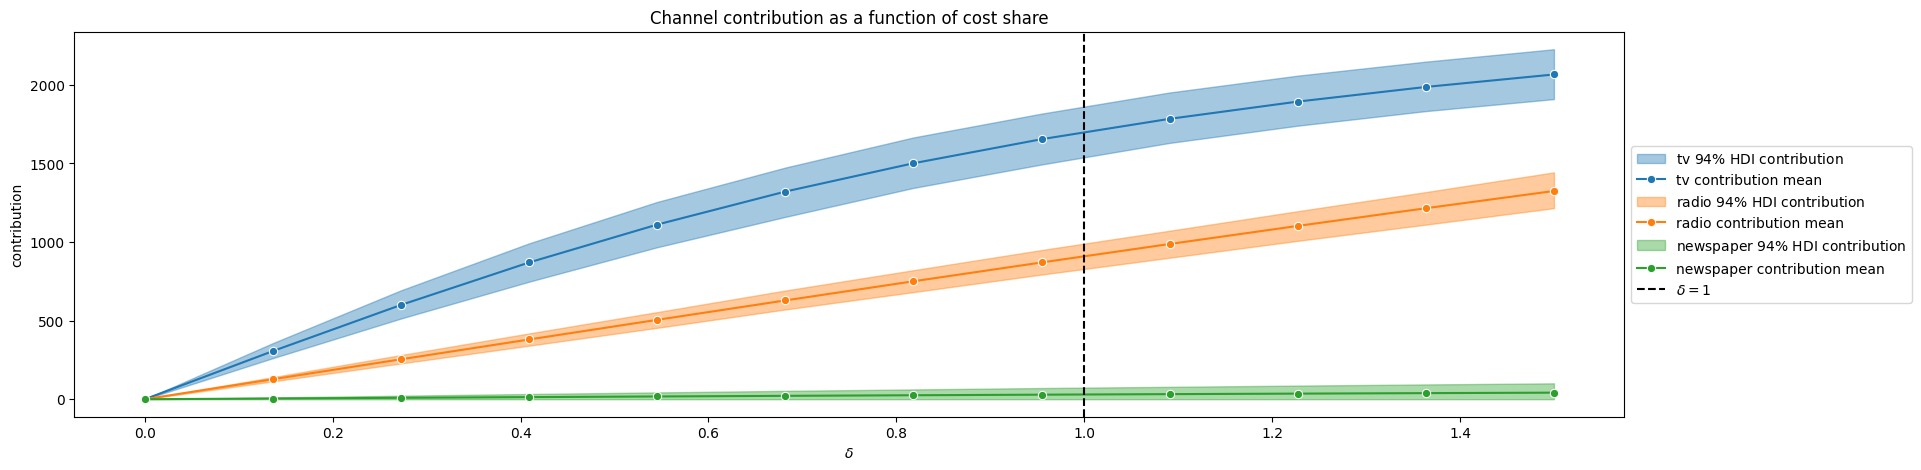

In [12]:
plt.rcParams["figure.figsize"] = (20,5)
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12);

### Evaluate Model in unseen data
 - Generate predictions for test set based on the media channels and control variables to check how good is our model in unseen data
 - We had a MAE of 2.01 for a target average of 13.8, pretty good! 
 - We are also better than a naive baseline that predicts always the average of the training data since our MAE is 58% lower.

In [1]:
y_out_of_sample = mmm.sample_posterior_predictive(X_pred=test_df[['ds', 'tv', 'radio', "newspaper", "seasonality", "trend"]], extend_idata=False)
y_pred = [np.median(x) for x in y_out_of_sample['y']]

print(f"MAE: {mean_absolute_error(test_df['sales'], y_pred)} for an average target of {test_df['sales'].mean()}")
print(f"MASE: {mean_absolute_error(test_df['sales'], y_pred)/mean_absolute_error(test_df['sales'], [train_df['sales'].mean()]*5)}")

MAE: 2.008733107943637 for an average target of 13.8
MASE: 0.41701581608539257


### Bayesian Model vs Linear Regression
- Comparing our Bayesian model with a linear regression that can also be used in this kind of problems

In [96]:
pipe = utils.define_pipeline(['tv', 'radio', 'newspaper', 'seasonality', 'trend'])
pipe.fit(train_df[['tv', 'radio', "newspaper", "seasonality", "trend"]], train_df["sales"]/max(train_df["sales"]))
y_pred_lr = pipe.predict(test_df[['tv', 'radio', "newspaper", "seasonality", "trend"]])*max(train_df["sales"])

print(f"MAE: {mean_absolute_error(test_df['sales'], y_pred_lr)} for an average target of {test_df['sales'].mean()}")
print(f"MASE: {mean_absolute_error(test_df['sales'], y_pred)/mean_absolute_error(test_df['sales'], y_pred_lr)}")

MAE: 1.4657562272129119 for an average target of 13.8
MASE: 1.3618601017347596


In [97]:
pipe['regressor'].coef_

array([ 0.49807255,  0.34193023, -0.00890966,  0.02992161,  0.00944032])

# Optimising Marketing Budget
- We start by determine which saturation curve better fits our data (sigmoid or Michaelis-Menten).
- In our case the sigmoid function performs better.

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/pymc_marketing/mmm/base.py:920: UserWarning: The curve optimization parameters method is experimental
  warnings.warn(


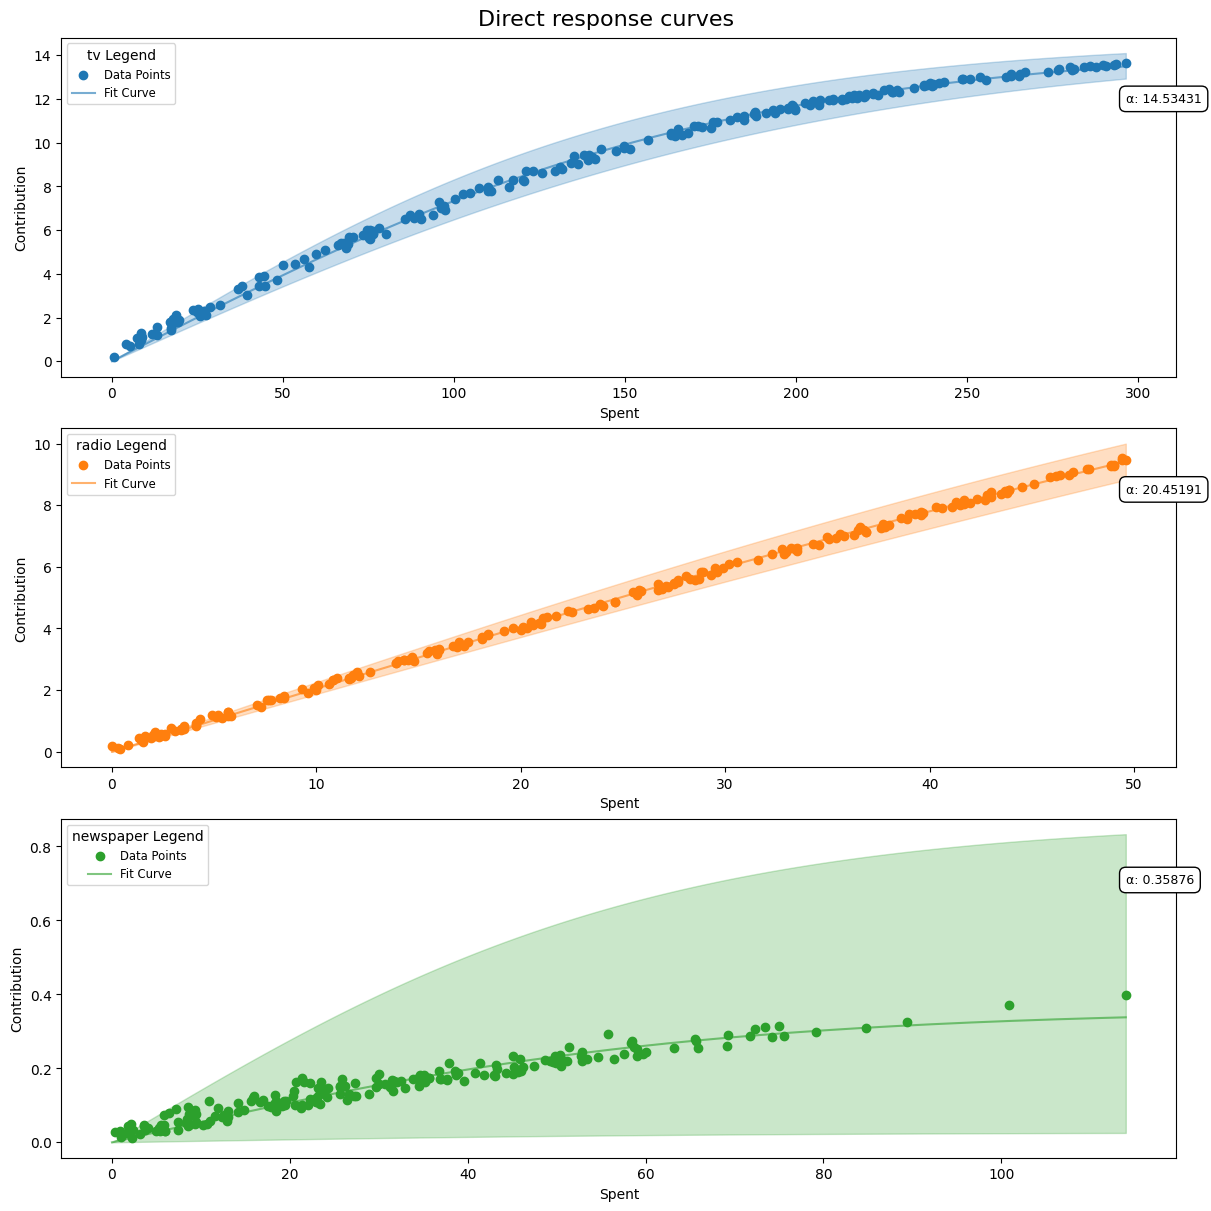

In [9]:
# sigmoid
sigmoid_response_curve_fig = mmm.plot_direct_contribution_curves(show_fit=True)
sigmoid_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='sigmoid')

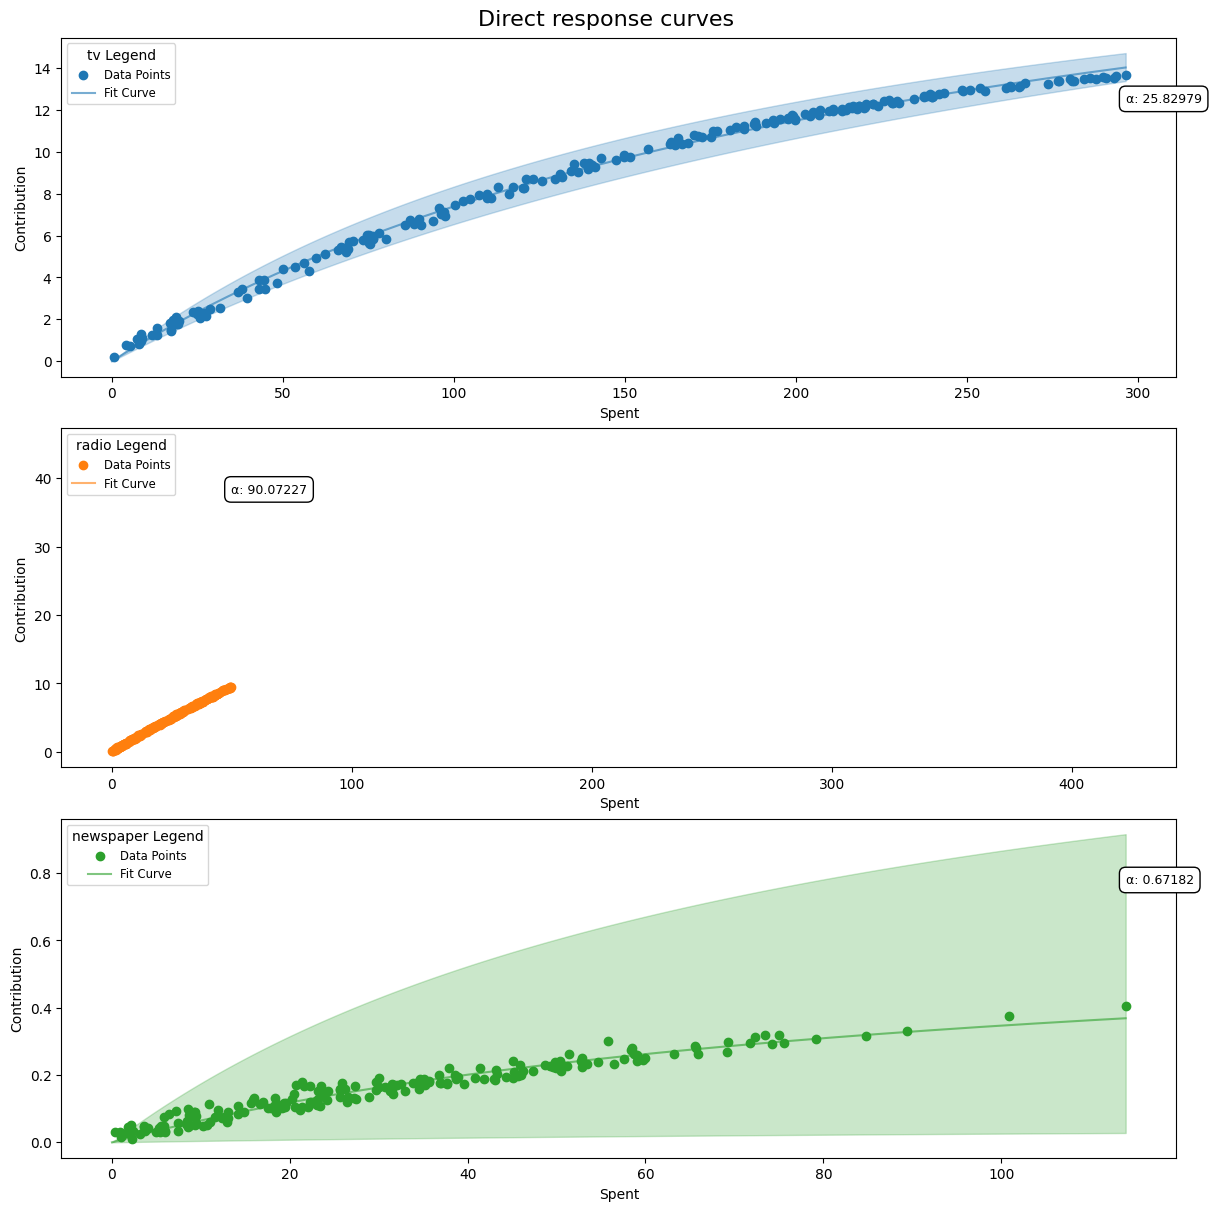

In [17]:
# Michaelis-Menten
mm_response_curve_fig = mmm.plot_direct_contribution_curves(show_fit = True, method='michaelis-menten')
mm_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='michaelis-menten')

- Once we have the parameters of the sigmoid function, we can optimise future budgets across the media channels using SLSQP algorithm.
- We just need to define the total budget and the budget constraints on a channel level.

In [13]:
result_sigmoid = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid', #define saturation function
    total_budget = 500, # total budget
    parameters = sigmoid_params, # sigmoid parameters extracted previously
    budget_bounds = {'tv': [75, 296], 'radio': [10, 300], 'newspaper': [1, 25]} # budget constraints by channel
)
result_sigmoid

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/pymc_marketing/mmm/base.py:890: UserWarning: This budget allocator method is experimental
  warnings.warn("This budget allocator method is experimental", UserWarning)


,estimated_contribution,optimal_budget
tv,13.418144,289.778437
radio,19.849194,209.221563
newspaper,0.005531,1.000000
total,33.272869,500.000000


- Now, imagine that you live under uncertain economic trends, you are tasked with designing a budget allocation strategy capable of accommodating various scenarios.
- The scenarios are:
    1. Recession Scenario: What if there is a market downturn and the budget gets cut by 40%? 
    2. Status Quo Scenario: What if the market stays stable? What we calculated in the previous cell
    3. Growth Scenario: What if the market suddenly becomes more favorable? How should the extra budget be allocated?
- We will use our fitted MMM model together with the sigmoid parameters provided by the model to estimate the allocation in each of the scenarios.

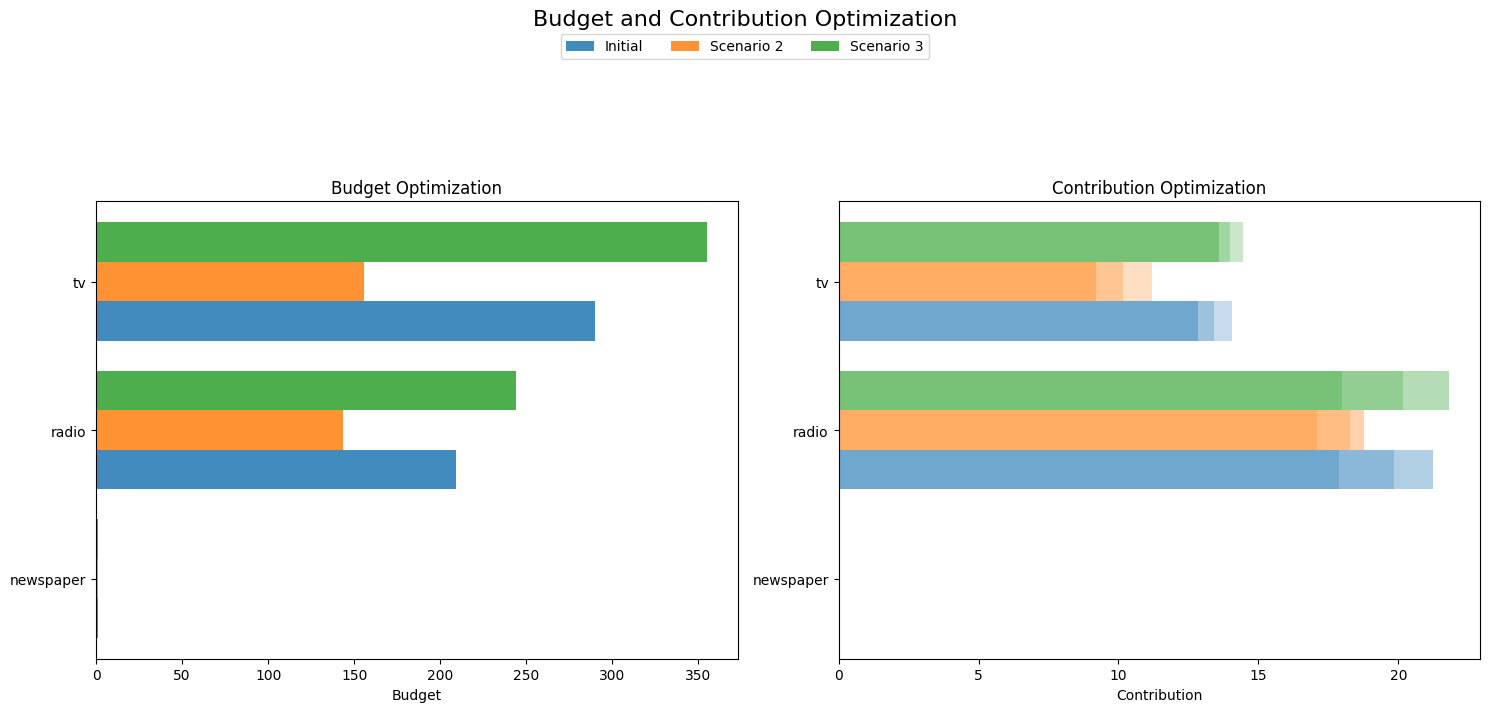

In [20]:
scenarios_result = []
total_budget = 500
channels = ['tv', 'radio', 'newspaper']

for scenario in np.array([0.6, 1.2]):
    scenarios_result.append(
        mmm.optimize_channel_budget_for_maximum_contribution(
            method="sigmoid",  # define saturation function
            total_budget=total_budget * scenario,
            parameters=sigmoid_params,
            budget_bounds={
                channel: [1, total_budget * scenario] for channel in channels
            },
        ).to_dict()
    )

_ = mmm.plot_budget_scenearios(
    base_data=result_sigmoid, method="sigmoid", scenarios_data=scenarios_result
)